# Waveform Featurization

### Colab Setup

In [ ]:
# For Colab (follow instructions at https://github.com/johnlyzhou/spike-sorting for local installation)

from google.colab import drive
from IPython.display import clear_output 

# Install packages and requirements
!git clone https://github.com/johnlyzhou/spike-sorting.git
%cd spike-sorting
!pip install -r requirements.txt
!pip install -e .
clear_output()

# Download sample waveform templates
!gdown --id 1FY86UUkV-QdPpAMQGzNiU-wN3W9dtPLo -O /content/spike-sorting/data/raw/templates_yass.npy 

Downloading...
From: https://drive.google.com/uc?id=1FY86UUkV-QdPpAMQGzNiU-wN3W9dtPLo
To: /content/spike-sorting/data/raw/templates_yass.npy
100% 63.2M/63.2M [00:00<00:00, 82.5MB/s]


### Import Statements

In [1]:
import h5py
from pathlib import Path

import numpy as np

from src.data.preprocess_templates import ( 
    get_max_chan_temps, 
    take_channel_range, 
    localize_wfs
)
from src.data.make_datasets import (
    featurization_dataset, 
    positional_invariance_dataset, 
    clustering_dataset,
    predict_ptp
)
from src.evaluation.visualize import plot_templates

from spike_psvae.point_source_centering import relocate_simple

In [2]:
# REPO_PATH = "/content/spike-sorting" # Colab
REPO_PATH = "/Users/johnzhou/research/spike-sorting" # Local
RAW_DATA_DIR = Path(f"{REPO_PATH}/data/raw")
PROCESS_DATA_DIR = Path(f"{REPO_PATH}/data/processed")

## Real Dataset Preprocessing

In [3]:
rec_fname = "ks_np2_nzy_cortex.h5"
rec_fpath = f"{RAW_DATA_DIR}/ks_np2_nzy_cortex.h5"

with h5py.File(rec_fpath, "r") as f:
    for k in f.keys():
        print(k, f[k].dtype, f[k].shape)
    wf_real = f['denoised_waveforms'][()]
    maxchans = f['max_channels'][()]
    first_chans = f['first_channels'][()]
    geom = f['geom'][()]
    x = f['x'][()]
    y = f['y'][()]
    z_rel = f['z_rel'][()]
    z_abs = f['z_abs'][()]
    alpha = f['alpha'][()]
    cluster_idxs = f['spike_index'][()]

alpha float64 (365181,)
denoised_waveforms float32 (365181, 121, 18)
first_channels int64 (365181,)
geom float64 (384, 2)
max_channels int64 (365181,)
maxptp float64 (365181,)
selection_indices int64 (365181,)
spike_index int64 (365181, 2)
spike_train int64 (365181, 2)
templates float64 (332, 121, 384)
x float64 (365181,)
y float64 (365181,)
z_abs float64 (365181,)
z_reg float64 (365181,)
z_rel float64 (365181,)


In [4]:
wf_relocated, r, q = relocate_simple(wf_real, geom, maxchans, x, y, z_rel, alpha, 
                                     channel_radius=8, firstchans=first_chans, geomkind="standard")

torch.Size([365181, 18])
365181
18


In [5]:
wf_relocated = wf_relocated.detach().numpy()

Template 0


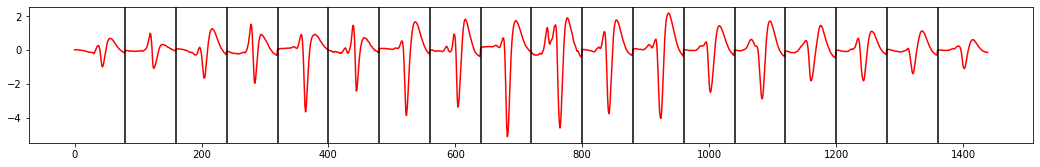

Template 1


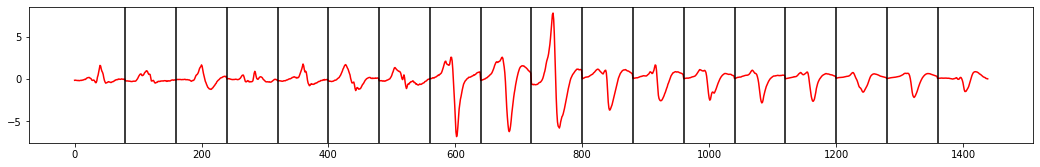

Template 2


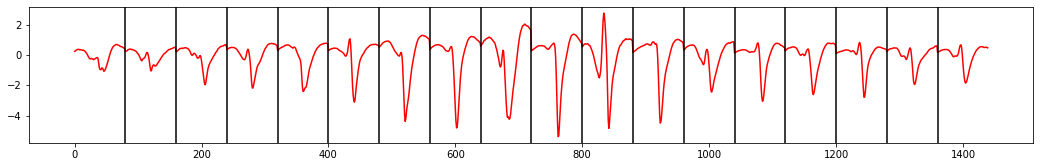

Template 3


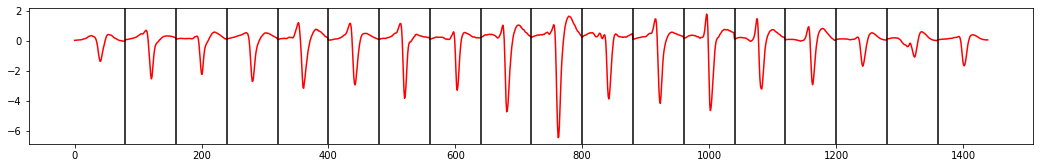

Template 4


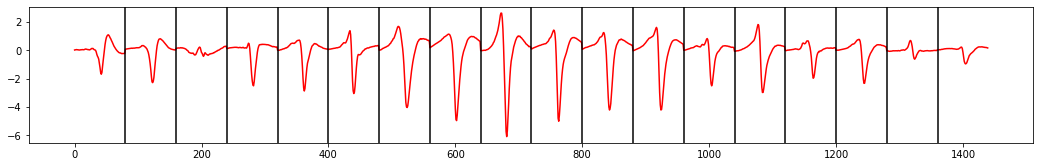

Template 5


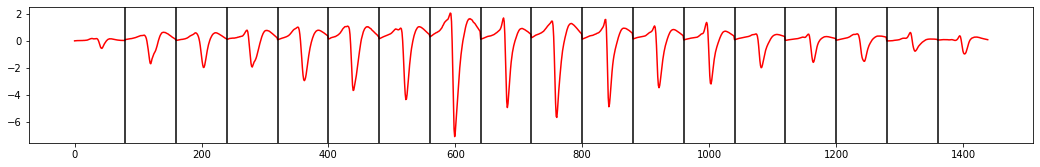

Template 6


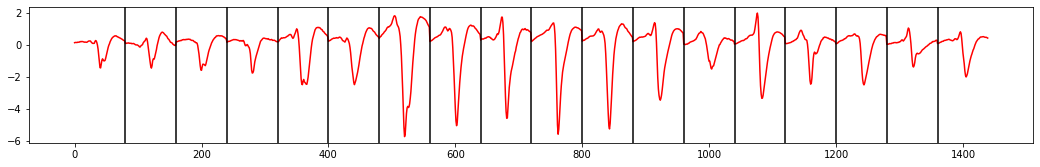

Template 7


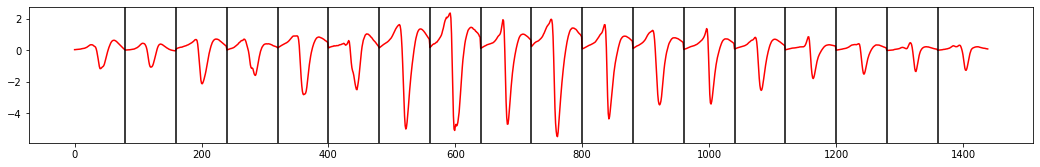

Template 8


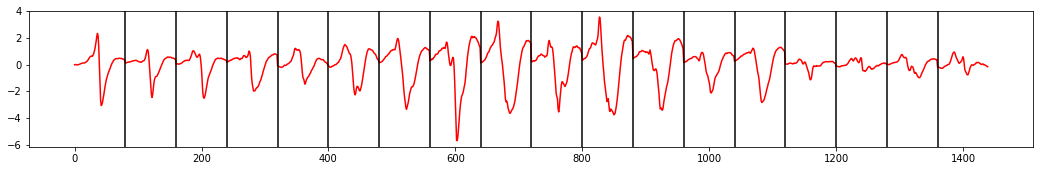

Template 9


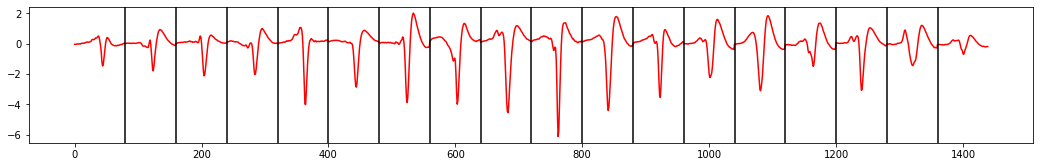

In [47]:
plot_templates(wf_relocated[:30, :, :], n_channels=18, n_templates=10)

In [6]:
cluster_idxs = cluster_idxs[:, 1]

In [37]:
from sklearn.decomposition import IncrementalPCA

def fit_pca(wfs, n_components=6, n_samples_train=100000):
    shuffler_idxs = np.random.permutation(wfs.shape[0])
    shuffle = shuffler_idxs[:n_samples_train]
    num_samples, num_timesteps, num_channels = wfs.shape
    wfs_flat = np.reshape(wfs[shuffle], (n_samples_train, num_timesteps * num_channels))
    ipca = IncrementalPCA(n_components=n_components)
    ipca.partial_fit(wfs_flat)
    return ipca

fitted_pca = fit_pca(wf_relocated)

In [38]:
num_samples, num_channels, num_timesteps = wf_relocated.shape
print(wf_relocated.shape)
wf_rep = fitted_pca.transform(np.reshape(wf_relocated, (num_samples, num_timesteps * num_channels)))

(365181, 121, 18)


In [41]:
print(wf_rep.shape, x.shape, cluster_idxs.shape)
wf_rep = np.stack((wf_rep[:, 0], wf_rep[:, 1], wf_rep[:, 2], x, y, z_abs, alpha, cluster_idxs))
print(wf_rep.shape)

(365181, 6) (365181,) (365181,)
(8, 365181)


In [60]:
unique_ids, counts = np.unique(cluster_idxs, return_counts=True)
cluster_ids_valid = np.array([unique_ids[i] for i in range(unique_ids.shape[0]) if counts[i] > 1000])
wf_ids_valid = np.squeeze(np.argwhere(np.isin(cluster_idxs, cluster_ids_valid)))
cluster_reps = wf_rep.T[wf_ids_valid]
cluster_reps = cluster_reps[np.argsort(cluster_reps[:, -1])]
print(cluster_reps.shape)
cluster_reps = (cluster_reps - np.mean(cluster_reps, axis=0)) / np.var(cluster_reps, axis=0)

(343862, 8)


In [61]:
cluster_unique, unique_idxs = np.unique(cluster_reps[:, -1], return_index=True)
idx_bounds = np.sort(unique_idxs)[1:]
clusters = np.vsplit(cluster_reps[:, :7], idx_bounds)
print([cluster.shape for cluster in clusters])
print(len(clusters))

[(2510, 7), (4338, 7), (2717, 7), (1228, 7), (16155, 7), (3950, 7), (2968, 7), (10687, 7), (36303, 7), (19913, 7), (2708, 7), (4450, 7), (4304, 7), (3326, 7), (7061, 7), (1786, 7), (4651, 7), (1240, 7), (7537, 7), (9661, 7), (1180, 7), (1090, 7), (1227, 7), (4796, 7), (9481, 7), (1017, 7), (4161, 7), (4075, 7), (7126, 7), (2013, 7), (8892, 7), (9882, 7), (6707, 7), (7067, 7), (2159, 7), (4579, 7), (4236, 7), (1493, 7), (7790, 7), (3607, 7), (4817, 7), (1485, 7), (3244, 7), (1596, 7), (3277, 7), (1945, 7), (10508, 7), (3004, 7), (6701, 7), (11544, 7), (3462, 7), (17713, 7), (4008, 7), (7880, 7), (2836, 7), (2713, 7), (2732, 7), (2267, 7), (3501, 7), (1706, 7), (4575, 7), (2277, 7)]
62


In [62]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import IncrementalPCA
import sklearn.metrics as skm

num_clusters = len(clusters)
neg_conf_matrix = np.zeros((num_clusters, num_clusters))
eval_metric = 'l2'
num_per_cluster = 1000

for i, cluster_a in enumerate(clusters):
    for j, cluster_b in enumerate(clusters):
        inter_cluster_dists = pairwise_distances(cluster_a[:num_per_cluster], 
                                                 cluster_b[:num_per_cluster], 
                                                           metric=eval_metric)
        avg_inter_cluster_dist = np.mean(inter_cluster_dists)
        neg_conf_matrix[i, j] = avg_inter_cluster_dist
        neg_conf_matrix[j, i] = avg_inter_cluster_dist

avg_intra_cluster_dists = np.mean(np.diagonal(neg_conf_matrix))
neg_conf_matrix /= avg_intra_cluster_dists

min_dist = np.min(neg_conf_matrix, axis=0)
rearrange = np.argsort(min_dist)
neg_conf_matrix = neg_conf_matrix[rearrange, :]
neg_conf_matrix = neg_conf_matrix[:, rearrange]
print("min:", np.min(neg_conf_matrix), "max:", np.max(neg_conf_matrix), 
      "median:", np.median(neg_conf_matrix), "mean:", np.mean(neg_conf_matrix))

min: 0.5835089062480079 max: 1.8065568189299037 median: 1.1632142567925732 mean: 1.1680368704529607


Text(0.5, 1.0, 'Average distance matrix between real clusters (PCA, 6 components)')

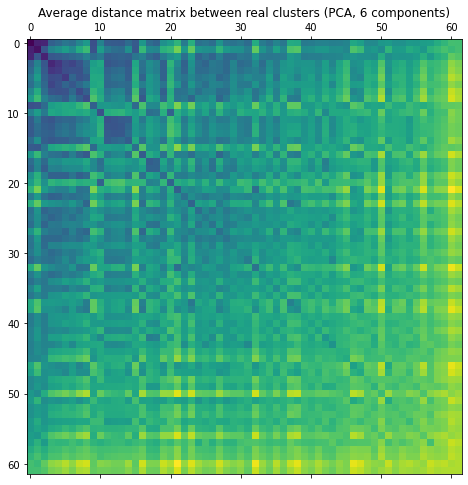

In [63]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 8))
ax1.matshow(np.log(neg_conf_matrix))

# add the title and label
ax1.set_title('Average distance matrix between real clusters (PCA, 6 components)')

In [49]:
# print(geom)
k = 5001
print(geom[first_channels[k] : first_channels[k] + 18] - [0, geom[max_channels[k], 1]])
# print(max_chan[:5])
# print(z_abs[:5])
# print(z_reg[:5])
print(z_rel[:5])

NameError: name 'first_channels' is not defined

## Synthetic Dataset Generation

### Load Data

In [ ]:
# Cleaned and denoised templates
templates_fname = "templates_yass.npy"
templates_fpath = Path(f"{RAW_DATA_DIR}/{templates_fname}")
templates = np.load(templates_fpath)
num_templates, num_timesteps, num_chans = templates.shape
print(f"{num_templates} templates, {num_timesteps} timesteps, {num_chans} channels.")

# Probe geometry
geom_fname = "channel_map_np2.npy"
geom_fpath = Path(f"{RAW_DATA_DIR}/{geom_fname}")
geom_array = np.load(geom_fpath)

# Raw recordings for noise
raw_10s_path = f"{RAW_DATA_DIR}/ten_np2_seconds.npy"

170 templates, 121 timesteps, 384 channels.


### Identify and Remove Bad Templates

     |████████████████████████████████| 13.1 MB 14.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.1
    Uninstalling matplotlib-3.3.1:
      Successfully uninstalled matplotlib-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


(170, 121, 384)
Template 0


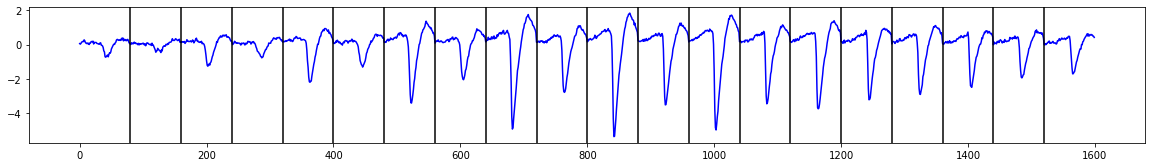

Template 1


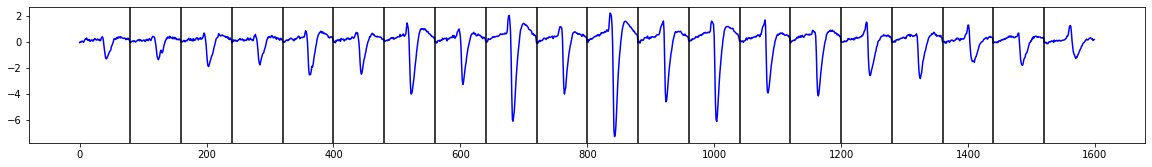

Template 2


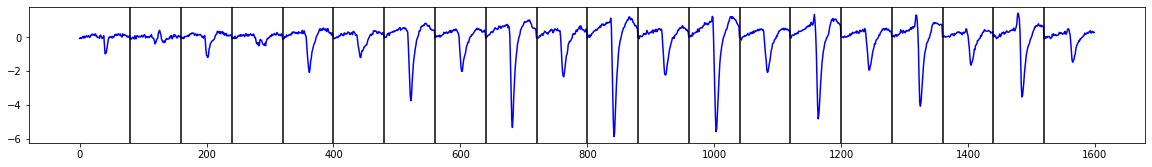

Template 3


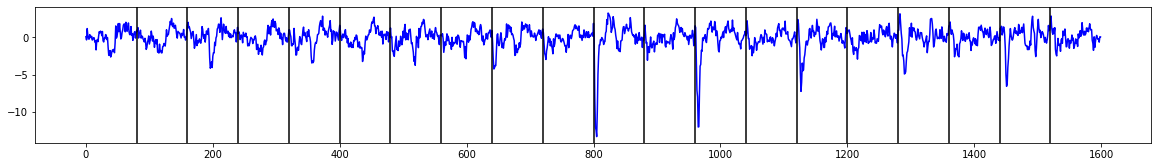

Template 4


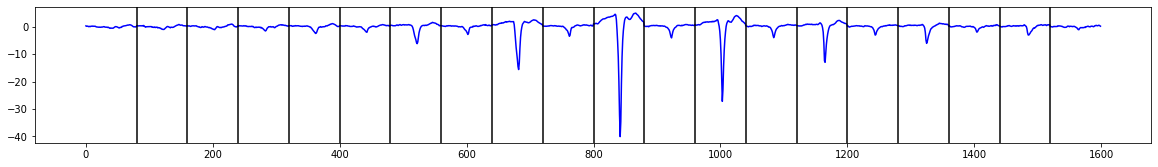

Template 5


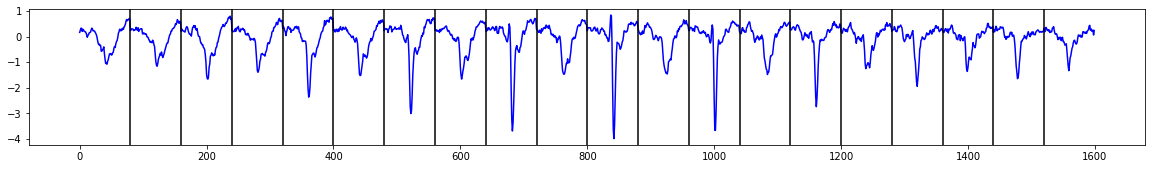

Template 6


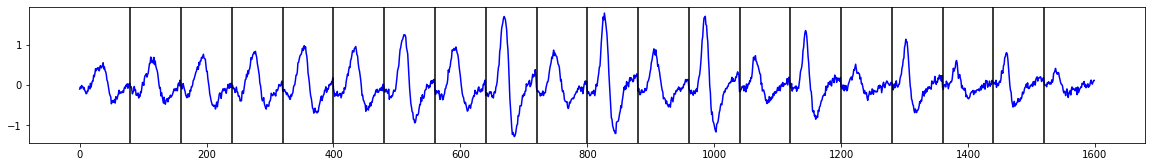

Template 7


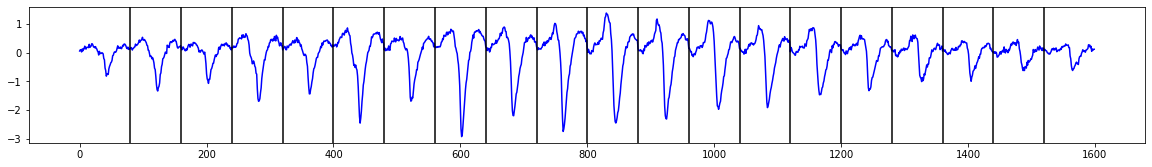

Template 8


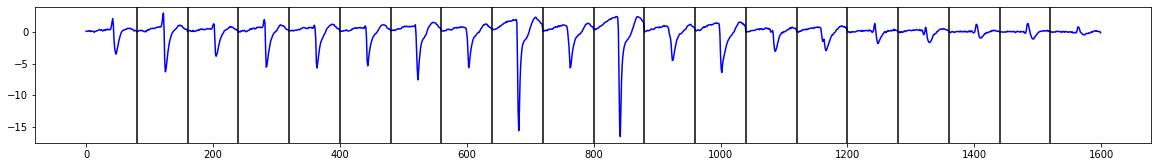

Template 9


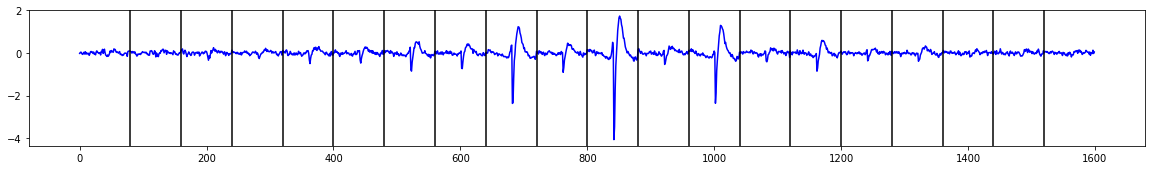

In [ ]:
!pip install matplotlib==3.1.3
# Number of channels to take around max channel
n_channels = 20
channel_positions = geom_array[:n_channels]

# Look at each template and note which ones are "bad", i.e. don't look like typical spikes
plot_templates(templates, n_channels=n_channels, n_templates=10)

In [ ]:
# Remove the bad templates by index
bad_template_idxs = [3, 6, 27, 29, 32, 35, 36, 56, 57, 58, 59, 62, 63, 64, 74, 78, 79, 80, 85, 91, 92, \
    101, 107, 109, 110, 111, 118, 119, 121, 145, 150, 151, 152, 157, 159, 164, 165, 169]
good_templates = np.delete(templates, bad_template_idxs, axis=0)
print(f"{good_templates.shape[0]} good templates remaining.")

132 good templates remaining.


### Take Channel Window and Localize Templates

In [ ]:
# Take the specified number of channels around the max channel
templates_chans, templates_ptp_chans = take_channel_range(good_templates, n_channels_loc=n_channels)
# Localize each template to a predicted position
template_positions = localize_wfs(templates_ptp_chans, geom_array)

100%|██████████| 132/132 [00:01<00:00, 69.89it/s]


### Generate Artificial Dataset

In [ ]:
# Gamma distribution parameters for alpha position variable.
a, loc, scale = 3, 100, 500

In [ ]:
featurize_train_experiment_name = "featurization_train"
featurize_val_experiment_name = "featurization_val"

train_frac = 0.8
n_samples = 100000

n_train_samples = round(n_samples * train_frac)
n_val_samples = round(n_samples * (1 - train_frac))

# Training data
featurization_dataset(
    templates_chans, template_positions, channel_positions, a, loc, scale, n_samples=n_train_samples, 
    noise_path=None,
    experiment_data_dir=PROCESS_DATA_DIR, 
    experiment_name=featurize_train_experiment_name
)
# Validation data
featurization_dataset(
    templates_chans, template_positions, channel_positions, a, loc, scale, n_samples=n_val_samples, 
    noise_path=None, 
    experiment_data_dir=PROCESS_DATA_DIR, 
    experiment_name=featurize_val_experiment_name
)

No noise to add to dataset


100%|██████████| 80000/80000 [03:49<00:00, 348.34it/s]


Saving templates to folder /content/spike-sorting/data/processed/featurization_train, array of shape: (80000, 20, 121)
Saving predicted PTPs to folder /content/spike-sorting/data/processed/featurization_train, array of shape: (80000, 20)
Saving positions to folder /content/spike-sorting/data/processed/featurization_train, array of shape: (80000, 4)
Saving unit indices to folder /content/spike-sorting/data/processed/featurization_train, array of shape: (80000,)
No noise to add to dataset


100%|██████████| 20000/20000 [00:54<00:00, 368.00it/s]


Saving templates to folder /content/spike-sorting/data/processed/featurization_val, array of shape: (20000, 20, 121)
Saving predicted PTPs to folder /content/spike-sorting/data/processed/featurization_val, array of shape: (20000, 20)
Saving positions to folder /content/spike-sorting/data/processed/featurization_val, array of shape: (20000, 4)
Saving unit indices to folder /content/spike-sorting/data/processed/featurization_val, array of shape: (20000,)


# Model Training

## Import Statements

In [ ]:
import json
import os
from pathlib import Path

import numpy as np
from omegaconf import OmegaConf
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint, EarlyStopping
from pl_bolts.callbacks import PrintTableMetricsCallback
from sklearn.decomposition import IncrementalPCA
import torch

from src.models.components import *
from src.models.spike_vae_module import *
from src.models.spike_psvae_module import *
from src.models.utils.train import train

## Training

In [ ]:
REPO_PATH = "/content/spike-sorting" # For Colab
# REPO_PATH = "/Users/johnzhou/research/spike-sorting"
PROCESS_DATA_DIR = Path(f"{REPO_PATH}/data/processed")
EXPT_DIR = Path(f"{REPO_PATH}/experiments")

featurize_train_experiment_name = "featurization_train"
featurize_val_experiment_name = "featurization_val"

train_template_path = f"{PROCESS_DATA_DIR}/{featurize_train_experiment_name}/templates.npy"
train_labels_path = f"{PROCESS_DATA_DIR}/{featurize_train_experiment_name}/positions.npy"
val_template_path = f"{PROCESS_DATA_DIR}/{featurize_val_experiment_name}/templates.npy"
val_labels_path = f"{PROCESS_DATA_DIR}/{featurize_val_experiment_name}/positions.npy"

### VAE

In [ ]:
"""
If GPUs are available, set "gpus" parameter. Modify data paths to match own file structure.
"""


base_config = OmegaConf.create({
    "random_seed": 4995,
    "model": {
        "in_channels": 20,
        "conv_encoder_layers": [[32, 5, 2], [16, 5, 2]],
        "conv_decoder_layers": [[16, 5, 2, 0], [20, 5, 2, 0]],
        "encoder_output_dim": [16, 28],
        "use_batch_norm": True
    },
    "learning_rate": 1e-4,
    "data": {
        "train_data_path": train_template_path,
        "val_data_path": val_template_path,
        "train_batch_size": 100,
        "val_batch_size": 100
    },
    "trainer": {
        "gpus": 1,
        "max_epochs": 100
    }

})

psvae_base_config = OmegaConf.merge(base_config, {
    "data": {
        "train_label_path": train_labels_path,
        "val_label_path": val_labels_path,
    },
    "anneal_epochs": 50
})

In [ ]:
vae_configs = [OmegaConf.merge(base_config, c) for c in [
    {
        "name": "vae_10latent",
        "model": {
            "latent_dim": 10
        }
    },
    {
        "name": "vae_8latent",
        "model": {
            "latent_dim": 8
        }
    },
    {
        "name": "vae_6latent",
        "model": {
            "latent_dim": 6
        }
    },
]]

expt_dir = f"{EXPT_DIR}/vae"
for config in vae_configs:
    system, trainer = train(
        SpikeSortingVAE,
        OmegaConf.to_container(config),
        experiment_dir=expt_dir,
        checkpoint_name="model")
    val_losses = trainer.validate()
    with open(f"{expt_dir}/{config['name']}/val_losses.json", "w") as f:
        json.dump(val_losses[0], f)

In [ ]:
drive.mount('/content/gdrive') # Mount Google Drive to save trained models
!cp -r /content/spike-sorting/experiments/vae '/content/gdrive/My Drive/Paninski Lab'

Mounted at /content/gdrive
